# Enron ML Project
***by Bruno de Assis Pereira***

---
In this project, I am going to present a development process of a **Machine Learning** model and I am going to use the [**Enron Dataset**](https://www.kaggle.com/wcukierski/enron-email-dataset).

This dataset contains emails generated by employees of the Enron Corporation and some informations related to finances. The Enron was involved in a huge fraude.

The goal here is to be able to identify **Persons of Interest (*POI*)**.

In [404]:
#!/usr/bin/python
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
from IPython.display import display

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Storing data in a dataframe to simplify data manipulation
enron_df = pd.DataFrame.from_dict(data_dict, orient='index')
display(enron_df.head(2))
enron_df.info()

### Removing an outlier identified in later sections
enron_df_clnd = enron_df.drop('TOTAL')

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


In [405]:
### Splitting data into Train x Test
from sklearn import cross_validation

### Replacing NaN's
enron_df.replace(to_replace={'NaN':0}, inplace=True)
enron_df_clnd.replace(to_replace={'NaN': 0}, inplace=True)

features = enron_df_clnd.drop(['poi', 'email_address'], axis=1)
labels = enron_df_clnd['poi']

features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    features, labels, test_size=0.3, random_state=42)

In [406]:
### Columns with negative values
(enron_df.T < 0).any(1)

salary                       False
to_messages                  False
deferral_payments             True
total_payments               False
exercised_stock_options      False
bonus                        False
restricted_stock              True
shared_receipt_with_poi      False
restricted_stock_deferred     True
total_stock_value             True
expenses                     False
loan_advances                False
from_messages                False
other                        False
from_this_person_to_poi      False
poi                          False
director_fees                False
deferred_income               True
long_term_incentive          False
email_address                False
from_poi_to_this_person      False
dtype: bool

In [407]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [408]:
### Task 1: Select what features you'll use.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Creates and fits selector
selector = SelectKBest(chi2, k=9)
selector.fit(features_train, labels_train)
### Get idxs of columns to keep
selected_idx = selector.get_support(indices=True)
### Applies selection over features
features_train_selected = selector.transform(features_train)
features_test_selected = selector.transform(features_test)

columns_list = enron_df[selected_idx].columns.tolist()
columns_list

['salary',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_stock_value',
 'loan_advances',
 'other']

---
### Looking for *Outliers*

---

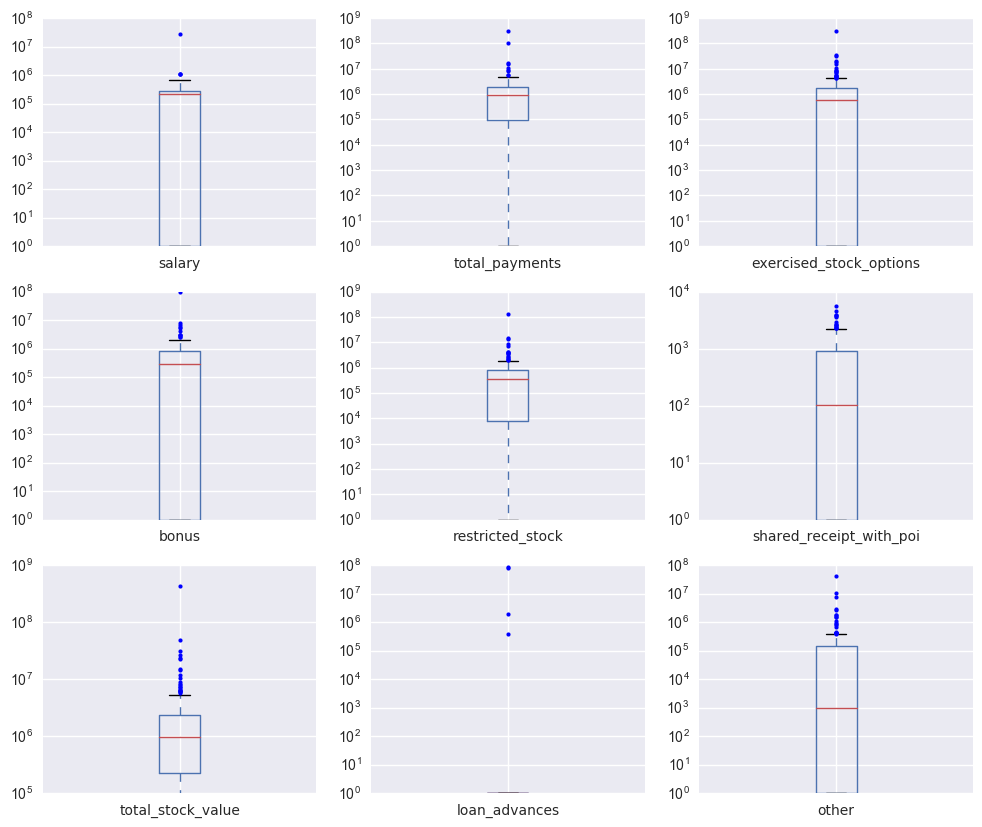

In [409]:
fig, axes = plt.subplots(3, 3, figsize=(12,10))

if 'poi' in columns_list:
    columns_list.remove('poi')
    
for i, x in enumerate(columns_list):
    ax=(enron_df[x]+1).plot(kind='box', ax=axes[i/3][i%3], sym='k.')
    ax.set_yscale('log')

In [410]:
def feature_details(df, feature, top_n=5, quantile=.95):
    col_idx = enron_df.columns.get_loc(feature)
    
    print '-------------------------\n{} score: '.format(feature), selector.scores_[col_idx]
    display(df[[feature, 'poi']].sort_values(by=feature, ascending=False)[:top_n])
    print '{}% of the data are less than or equal to the following value: '.format(quantile*100)\
        ,df[feature].quantile(quantile)

In [411]:
feature_details(enron_df,'loan_advances', 6, .97)

-------------------------
loan_advances score:  5.97951757323


,loan_advances,poi
TOTAL,83925000,False
LAY KENNETH L,81525000,True
FREVERT MARK A,2000000,False
PICKERING MARK R,400000,False
ALLEN PHILLIP K,0,False
MEYER ROCKFORD G,0,False


97.0% of the data are less than or equal to the following value:  0.0


---
In the case above, we can see that the ``loan_advances`` feature presents **four** outliers.

The **TOTAL** does not make sense to be part of this analysis, so this entire line will be removed from the dataset.

For the other three, we see that one of them is a ***POI***. However, at least **97% of the data** has a *loan_advance* of 0.

Let's analyse in the same way for the other selected variables.

---

In [412]:
for c in columns_list:
    if c != 'loan advances':
        feature_details(enron_df, c)

-------------------------
salary score:  2.34701865955


,salary,poi
TOTAL,26704229,False
SKILLING JEFFREY K,1111258,True
LAY KENNETH L,1072321,True
FREVERT MARK A,1060932,False
PICKERING MARK R,655037,False


95.0% of the data are less than or equal to the following value:  437718.5
-------------------------
total_payments score:  3.17982539659


,total_payments,poi
TOTAL,309886585,False
LAY KENNETH L,103559793,True
FREVERT MARK A,17252530,False
BHATNAGAR SANJAY,15456290,False
LAVORATO JOHN J,10425757,False


95.0% of the data are less than or equal to the following value:  5601164.75
-------------------------
exercised_stock_options score:  5.88813825573


,exercised_stock_options,poi
TOTAL,311764000,False
LAY KENNETH L,34348384,True
HIRKO JOSEPH,30766064,True
RICE KENNETH D,19794175,True
SKILLING JEFFREY K,19250000,True


95.0% of the data are less than or equal to the following value:  8701072.75
-------------------------
bonus score:  5.6236753127


,bonus,poi
TOTAL,97343619,False
LAVORATO JOHN J,8000000,False
LAY KENNETH L,7000000,True
SKILLING JEFFREY K,5600000,True
BELDEN TIMOTHY N,5249999,True


95.0% of the data are less than or equal to the following value:  3000000.0
-------------------------
restricted_stock score:  2.47132074331


,restricted_stock,poi
TOTAL,130322299,False
LAY KENNETH L,14761694,True
WHITE JR THOMAS E,13847074,False
PAI LOU L,8453763,False
SKILLING JEFFREY K,6843672,True


95.0% of the data are less than or equal to the following value:  3870737.5
-------------------------
shared_receipt_with_poi score:  2.28883548836


,shared_receipt_with_poi,poi
BELDEN TIMOTHY N,5521,True
SHAPIRO RICHARD S,4527,False
LAVORATO JOHN J,3962,False
WHALLEY LAWRENCE G,3920,False
KITCHEN LOUISE,3669,False


95.0% of the data are less than or equal to the following value:  2663.75
-------------------------
total_stock_value score:  4.76287984724


,total_stock_value,poi
TOTAL,434509511,False
LAY KENNETH L,49110078,True
HIRKO JOSEPH,30766064,True
SKILLING JEFFREY K,26093672,True
PAI LOU L,23817930,False


95.0% of the data are less than or equal to the following value:  13937828.25
-------------------------
loan_advances score:  5.97951757323


,loan_advances,poi
TOTAL,83925000,False
LAY KENNETH L,81525000,True
FREVERT MARK A,2000000,False
PICKERING MARK R,400000,False
ALLEN PHILLIP K,0,False


95.0% of the data are less than or equal to the following value:  0.0
-------------------------
other score:  1.73855169367


,other,poi
TOTAL,42667589,False
LAY KENNETH L,10359729,True
FREVERT MARK A,7427621,False
MARTIN AMANDA K,2818454,False
BAXTER JOHN C,2660303,False


95.0% of the data are less than or equal to the following value:  1568425.25


---
Besides the **TOTAL** row, based on the *box plots* and the tables above, it is possible to see that all features presents outliers.

The thing is that sometimes those _outliers_ are related to ***POIs***. For this reason, I will keep them during the analysis, but it is good to keep these behaviours in mind. 

---

In [413]:
### From now on, the dataframe that is been used is 'enron_df_clnd'
### This dataframe does not contain outliers

In [ ]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [414]:
### Task 4: Try a variety of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

clf = GaussianNB()
clf.fit(features_train_selected, labels_train)

pred = clf.predict(features_test_selected)

print 'accuracy_score:', accuracy_score(labels_test, pred)
print 'precision_score:', precision_score(labels_test, pred)
print 'recall_score:', recall_score(labels_test, pred)

accuracy_score: 0.863636363636
precision_score: 0.25
recall_score: 0.25


In [483]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# {'accuracy_score': 0.84090909090909094,
#   'classifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
#               max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
#               min_samples_split=6, min_weight_fraction_leaf=0.0,
#               presort=False, random_state=511, splitter='best'),
#   'name': 'Decision Tree',
#   'precision_score': 0.33333333333333331,
#   'recall_score': 0.75}

# {'accuracy_score': 0.93181818181818177,
#   'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#               max_depth=10, max_features=1, max_leaf_nodes=None,
#               min_samples_leaf=1, min_samples_split=2,
#               min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
#               oob_score=False, random_state=511, verbose=0, warm_start=False),
#   'name': 'Random Forest',
#   'precision_score': 0.66666666666666663,
#   'recall_score': 0.5}

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5, min_samples_split=9, random_state=511),
    RandomForestClassifier(max_depth=10, n_estimators=5, max_features=1, random_state=511),
    AdaBoostClassifier(),
    GaussianNB()]

result = []
for name, clf in zip(names, classifiers):
    clf.fit(features_train_selected, labels_train)
    
    pred = clf.predict(features_test_selected)
    
    result.append({
        'name': name,
        'classifier': clf,
        'accuracy_score': accuracy_score(labels_test, pred),
        'precision_score': precision_score(labels_test, pred),
        'recall_score': recall_score(labels_test, pred)
    })

result

[{'accuracy_score': 0.88636363636363635,
  'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  'name': 'Nearest Neighbors',
  'precision_score': 0.0,
  'recall_score': 0.0},
 {'accuracy_score': 0.90909090909090906,
  'classifier': SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  'name': 'Linear SVM',
  'precision_score': 0.0,
  'recall_score': 0.0},
 {'accuracy_score': 0.90909090909090906,
  'classifier': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  'name': 'RBF SVM',
  'precision_score': 0.0

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

---
### References
---